# Prediction with RNN

In [15]:
import numpy as np
import pandas as pd
from datetime import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Masking,Embedding,Bidirectional,TimeDistributed
#%tensorflow_version 2.x

In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=None, val_df=None, test_df=None,
               label_columns=None, mean = 0, std = 1):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.mean = mean
        self.std = std

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label slice: {self.labels_slice}',
            f'Input Slice: {self.input_slice}',
            f'Label column name(s): {self.label_columns}'])
    
    def plot(self, plot_col, model=None, max_subplots=3):
        inputs, labels = self.example
        
        
        plot_col_index = self.column_indices[plot_col]
        print("col index",plot_col_index)
        max_n = min(max_subplots, len(inputs))
        plt.figure(figsize=(12, 3*max_n))

        inputs_denorm = (inputs*std)+mean
        labels_denorm = (labels*std[plot_col_index])+mean[plot_col_index]

        for n in range(max_n):
            plt.subplot(max_subplots, 1, n+1)
            #plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs_denorm[n, :, plot_col_index],
                     label='Inputs', c='#007bff')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(self.label_indices, labels_denorm[n, :, label_col_index], label='Labels', c='#ffc107')

            if model is not None:
                #print((self.label_indices).shape)
                #print((labels_denorm).shape)
                #print(inputs.shape)
                predictions = model(inputs)
                #print("prediction shape", predictions.shape)
                #print("prediction itself",predictions)
                predictions_denorm = (predictions*std[plot_col_index])+mean[plot_col_index]
                plt.plot(self.label_indices, predictions_denorm[n, :, label_col_index],
                          label='Predictions',
                          c='#dc3545')

            if n == 0:
                plt.legend()

            #plt.xticks(np.arange(0,48,2))

        
        plt.suptitle("Prediction of "+plot_col)
        plt.xlabel('Time [h]')
        #plt.ylabel('Temperature [°C]')
        
    def plot2(self,  plot_col,model=None, max_subplots=3):
        inputs, labels = self.example2
        
        
        plot_col_index = self.column_indices[plot_col]
        print("col index",plot_col_index)
        max_n = min(max_subplots, len(inputs))
        plt.figure(figsize=(12, 3*max_n))

        inputs_denorm = (inputs*std)+mean
        labels_denorm = (labels*std[plot_col_index])+mean[plot_col_index]

        for n in range(max_n):
            plt.subplot(max_subplots, 1, n+1)
            #plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs_denorm[n, :, plot_col_index],
                     label='Inputs', c='#007bff', marker='*')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(self.label_indices, labels_denorm[n, :, label_col_index], label='Labels', c='#ffc107',marker='*')

            if model is not None:
                #print((self.label_indices).shape)
                #print((labels_denorm).shape)
                #print(inputs.shape)
                predictions = model(inputs)
                #print("prediction shape", predictions.shape)
                #print("prediction itself",predictions)
                predictions_denorm = (predictions*std[plot_col_index])+mean[plot_col_index]
                plt.plot(self.label_indices, predictions_denorm[n, :, label_col_index],
                          label='Predictions',
                          c='#dc3545', marker='o')

            if n == 0:
                plt.legend()

            #plt.xticks(np.arange(0,48,2))

        
        plt.suptitle("Prediction of "+plot_col)
        plt.xlabel('TimeSteps')
        #plt.ylabel('Temperature [°C]')
    def get_train(self):
        return self.train
        
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.test))
    self._example = result
    return result

@property
def example2(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = next(iter(self.test))
    return result

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=False,
          batch_size=32)

    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.example2 = example2

## Carico i dati da *eplusout.csv*

In [17]:

df1=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno1/eplusout/eplusout.csv')
df2=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno2/eplusout/eplusout.csv')
df3=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno3/eplusout/eplusout.csv')


In [18]:
def changetime(df,year):
    datetimeform = []
    for i in range(len(df.index)):
        tt = df["Date/Time"][i]
        days, hours = tt.split('  ')
        tt = f'{days.split("/")[1]}/{days.split("/")[0]}/{year}{hours}'
        tt = tt.replace(' ', '')
        if '201724:' or '201824:' or '201924:' in tt:
            tt=tt.replace('24:', '00:')
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            timestamp += 86400
            #timestamp = datetime.fromtimestamp(timestamp)

        else:
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            #timestamp = datetime.fromtimestamp(timestamp)
        datetimeform.append(timestamp)

    df["TimeStep"]=datetimeform
    
changetime(df1,"2017")
changetime(df2,"2018")
changetime(df3,"2019")
df1.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),...,DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),TimeStep
0,04/01 00:10:00,15.433333,NaN,10.3,NaN,101250.666667,NaN,3.0,NaN,19.166667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
1,04/01 00:20:00,14.366667,NaN,10.0,NaN,101280.333333,NaN,2.9,NaN,8.333333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
2,04/01 00:30:00,13.300000,NaN,9.7,NaN,101310.000000,NaN,2.8,NaN,357.500000,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
3,04/01 00:40:00,12.233333,NaN,9.4,NaN,101339.666667,NaN,2.7,NaN,346.666667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
4,04/01 00:50:00,11.166667,NaN,9.1,NaN,101369.333333,NaN,2.6,NaN,335.833333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491087e+09


In [19]:
df1.shape

(26352, 204)

In [20]:
# Extract mean temp time series
# mean value of the 3 indoor zones
def meanDF(df):
    df_mean = pd.DataFrame()
    #"Date/Time",\
    #"Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",\
    #"Electricity:Facility [J](TimeStep)"
    df_mean = df[[
              "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)",\
              ]]
    df_temp=df_mean.copy()
    df_temp.dropna(inplace=True)
    df_temp["mean"] = df_temp.mean(1)


    df_final=pd.DataFrame()
    df_final["DateTime"] = df["TimeStep"]
    df_final["Outdoor_Mean"] = df["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"]
    df_final["Indoor_Mean"] = df_temp["mean"]
    df_final["Cooling"] = df["DistrictCooling:Facility [J](TimeStep)"]
    df_final["Power"]=df["Electricity:Facility [J](TimeStep)"]
    df_final["Delta_T"] = df_final["Indoor_Mean"]-df_final["Outdoor_Mean"]
    
    #df_final
    return df_final

df1_final=meanDF(df1)
df2_final=meanDF(df2)
df3_final=meanDF(df3)
df1_final.head()

,DateTime,Outdoor_Mean,Indoor_Mean,Cooling,Power,Delta_T
0,1.491085e+09,15.433333,24.517612,0.0,27449.355191,9.084278
1,1.491085e+09,14.366667,24.406119,0.0,27449.355191,10.039452
2,1.491086e+09,13.300000,24.285492,0.0,27449.355191,10.985492
3,1.491086e+09,12.233333,24.168972,0.0,27449.355191,11.935639
4,1.491087e+09,11.166667,24.055292,0.0,27449.355191,12.888626


In [21]:
# selecting only the values to train the rnn on 
x = pd.DataFrame()
meas = ["TimeStep",
        'Electricity:Facility [J](TimeStep)',
        'DistrictCooling:Facility [J](TimeStep)',
        "Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
        "Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)",
        "Environment:Site Wind Speed [m/s](TimeStep)",
        "Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)",
        "Environment:Site Wind Direction [deg](TimeStep)",
        "Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)"]

x["Indoor_Mean"] = pd.concat([df1_final["Indoor_Mean"],df2_final["Indoor_Mean"],df3_final["Indoor_Mean"]])
print(x[78000:])
for m in meas:
    x[m]=pd.concat([df1[m],df2[m],df3[m]])
#x.set_index("TimeStep",inplace=True)
#x.head()
x.reset_index(inplace=True,drop=True)

       Indoor_Mean
25296    26.000000
25297    26.000000
25298    26.000000
25299    26.000000
25300    26.000000
...            ...
26347    25.519421
26348    25.520341
26349    25.523280
26350    25.525185
26351    25.526641

[1056 rows x 1 columns]


In [22]:
print(x.loc[x['Indoor_Mean']>26.2])

       Indoor_Mean      TimeStep  Electricity:Facility [J](TimeStep)  \
13722    26.362378  1.499318e+09                       439650.664800   
13723    26.396753  1.499318e+09                       439650.664800   
13724    26.663811  1.499319e+09                       439650.664800   
13725    26.548651  1.499320e+09                       439650.664800   
13726    26.523611  1.499320e+09                       439650.664800   
13727    26.548352  1.499321e+09                       439650.664800   
14299    26.236873  1.499664e+09                       435307.988468   
14300    26.309259  1.499665e+09                       435307.988468   
14301    26.285986  1.499665e+09                       435307.988468   
14302    26.231235  1.499666e+09                       435307.988468   
17755    26.588994  1.501738e+09                       439650.664800   
17756    26.648139  1.501738e+09                       439650.664800   
17757    26.244823  1.501739e+09                       439650.66

In [23]:
column_indices = {name: i for i, name in enumerate(x.columns)}
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Indoor_Mean,79056.0,2.569170e+01,5.149946e-01,2.190223e+01,2.545486e+01,2.600000e+01,2.600000e+01,2.666381e+01
TimeStep,79056.0,1.530525e+09,2.615061e+07,1.491084e+09,1.502942e+09,1.530525e+09,1.558108e+09,1.569967e+09
Electricity:Facility [J](TimeStep),79056.0,1.306167e+05,1.593147e+05,2.744936e+04,2.744936e+04,2.744936e+04,3.394476e+05,5.384741e+05
DistrictCooling:Facility [J](TimeStep),79056.0,6.310116e+05,4.708801e+05,0.000000e+00,1.929206e+05,5.549145e+05,1.050636e+06,1.905375e+06
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),79056.0,2.435966e+01,5.218590e+00,6.200000e+00,2.109583e+01,2.480000e+01,2.830000e+01,3.800000e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,2.837174e+02,3.359258e+02,0.000000e+00,0.000000e+00,4.700000e+01,6.553333e+02,9.190000e+02
Environment:Site Wind Speed [m/s](TimeStep),79056.0,3.948260e+00,2.656548e+00,0.000000e+00,1.900000e+00,3.350000e+00,5.600000e+00,1.650000e+01
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),79056.0,1.010223e+05,3.484209e+02,9.968200e+04,1.007928e+05,1.011000e+05,1.012970e+05,1.022000e+05
Environment:Site Wind Direction [deg](TimeStep),79056.0,2.097937e+02,8.884432e+01,0.000000e+00,1.716667e+02,2.166667e+02,2.800000e+02,3.598333e+02
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,8.063162e+01,9.072162e+01,0.000000e+00,0.000000e+00,5.100000e+01,1.455000e+02,5.320000e+02


In [24]:
num_features = x.shape[1]
print(num_features)

10


## Split dataset into train, validation and test and normalize data

In [25]:
ntot = len(x)

#first two years for trainig 

x_train = x[:(len(df1)+len(df2))]
#x_train.set_index("TimeStep",inplace=True)
mean = x_train.mean()
std = x_train.std()
x_train_norm = (x_train - mean)/std
print("Training set dimension: ",len(x_train))

x_val =  x[(len(df1)+len(df2)): (len(df1)+len(df2)) + int(0.5*len(df3)) ]
#x_val.set_index("TimeStep",inplace=True)
x_val_norm = (x_val-mean)/std
print("Validation set dimension: ",len(x_val))

x_test =  x[(len(df1)+len(df2)) + int(0.5*len(df3)):]
#x_test.set_index("TimeStep",inplace=True)
x_test_norm = (x_test-mean)/std
print("Test set dimension: ",len(x_test))

Training set dimension:  52704
Validation set dimension:  13176
Test set dimension:  13176


<AxesSubplot:>

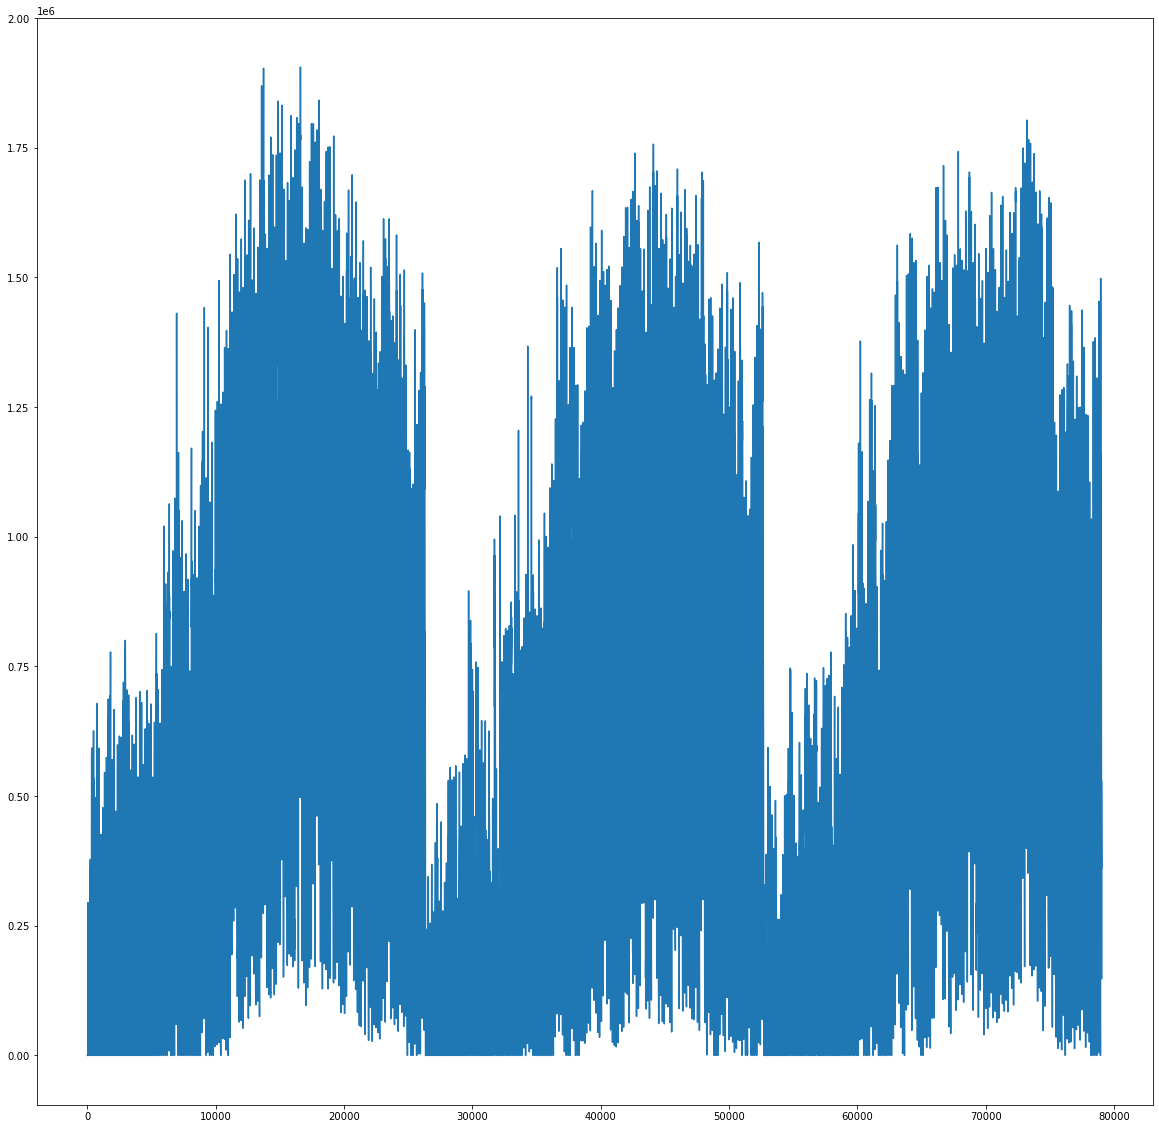

In [26]:
powr2 = x.copy()
#powr2=powr[0:1000]
powr2['DistrictCooling:Facility [J](TimeStep)'].plot(figsize=(20,20))
#powr2['Electricity:Facility [J](TimeStep)'].plot(figsize=(20,20))

#powr2.head(100)

<AxesSubplot:>

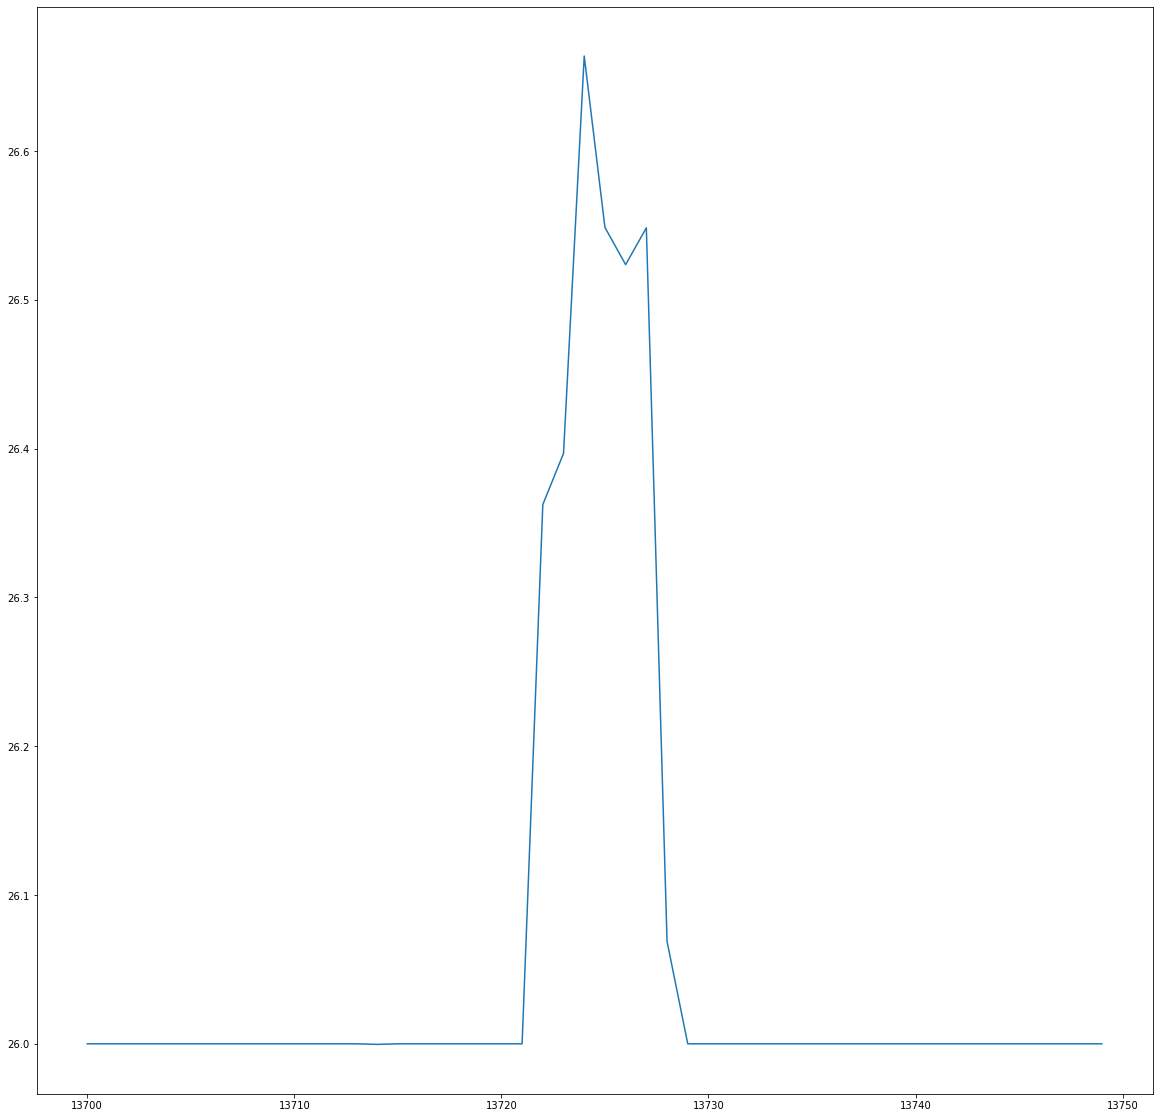

In [27]:
temp=x.copy()
#temp.set_index('TimeStep',inplace=True)
temp['Indoor_Mean'][13700:13750].plot(figsize=(20,20))

In [28]:
#column_to_predict = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
column_to_predict_indoor = 'Indoor_Mean'
w_indoor = WindowGenerator(input_width=6*24, label_width=6*24, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_indoor],
                     mean = mean, std = std)

In [29]:
column_to_predict_outdoor = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
w_outdoor = WindowGenerator(input_width=6*24*7, label_width=6*24, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_outdoor],
                     mean = mean, std = std)

In [30]:
column_to_predict_outdoor_wide = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
w_outdoor_wide = WindowGenerator(input_width=6*24*7, label_width=6*24*2, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_outdoor_wide],
                     mean = mean, std = std)

In [31]:
column_to_predict_power = 'Electricity:Facility [J](TimeStep)'
w_power = WindowGenerator(input_width=6*2, label_width=2, shift=1,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_power],
                     mean = mean, std = std)

In [32]:
column_to_predict_cooling = 'DistrictCooling:Facility [J](TimeStep)'
w_cooling = WindowGenerator(input_width=6*2, label_width=2, shift=2,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_cooling],
                     mean = mean, std = std)

In [33]:
w_cooling

Total window size: 14
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13]
Label slice: slice(12, None, None)
Input Slice: slice(0, 12, None)
Label column name(s): ['DistrictCooling:Facility [J](TimeStep)']

In [34]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    #different choices
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      batch_size=32)
    return history

In [35]:
x_train.shape

(52704, 10)

#this one works
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(12, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(2*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([2, 1])
])



#model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
#model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
#model.add(LSTM(32))  # return a single vector of dimension 32
#model.add(Dense(10, activation='softmax'))

In [36]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(36, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.LSTM(12, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(2*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([2, 1])
])

In [37]:
history = compile_and_fit(multi_lstm_model, w_cooling)

Epoch 1/20
1647/1647 [==============================] - 31s 19ms/step - loss: 0.0904 - mean_absolute_error: 0.2068 - val_loss: 0.0789 - val_mean_absolute_error: 0.2045
Epoch 2/20
1647/1647 [==============================] - 30s 18ms/step - loss: 0.0337 - mean_absolute_error: 0.1270 - val_loss: 0.0467 - val_mean_absolute_error: 0.1612
Epoch 3/20
1647/1647 [==============================] - 29s 18ms/step - loss: 0.0250 - mean_absolute_error: 0.1073 - val_loss: 0.0312 - val_mean_absolute_error: 0.1240
Epoch 4/20
1647/1647 [==============================] - 28s 17ms/step - loss: 0.0216 - mean_absolute_error: 0.0984 - val_loss: 0.0231 - val_mean_absolute_error: 0.1045
Epoch 5/20
1647/1647 [==============================] - 28s 17ms/step - loss: 0.0193 - mean_absolute_error: 0.0910 - val_loss: 0.0205 - val_mean_absolute_error: 0.0921
Epoch 6/20
1647/1647 [==============================] - 28s 17ms/step - loss: 0.0178 - mean_absolute_error: 0.0864 - val_loss: 0.0179 - val_mean_absolute_error:

In [38]:
multi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 36)            6768      
_________________________________________________________________
dropout (Dropout)            (None, 12, 36)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                2352      
_________________________________________________________________
dense (Dense)                (None, 2)                 26        
_________________________________________________________________
reshape (Reshape)            (None, 2, 1)              0         
Total params: 9,146
Trainable params: 9,146
Non-trainable params: 0
_________________________________________________________________


In [39]:
IPython.display.clear_output()
val_performance = {}
val_performance['LSTM'] = multi_lstm_model.evaluate(w_cooling.val)
performance={}
performance['LSTM'] = multi_lstm_model.evaluate(w_cooling.test, verbose=0)

412/412 [==============================] - 2s 4ms/step - loss: 0.0151 - mean_absolute_error: 0.0762


In [40]:
#w_cooling.plot(model=multi_lstm_model, plot_col = column_to_predict_cooling, max_subplots=3)
#print((self.label_indices).shape)
#print((labels_denorm).shape)
#print(inputs.shape)

col index 3


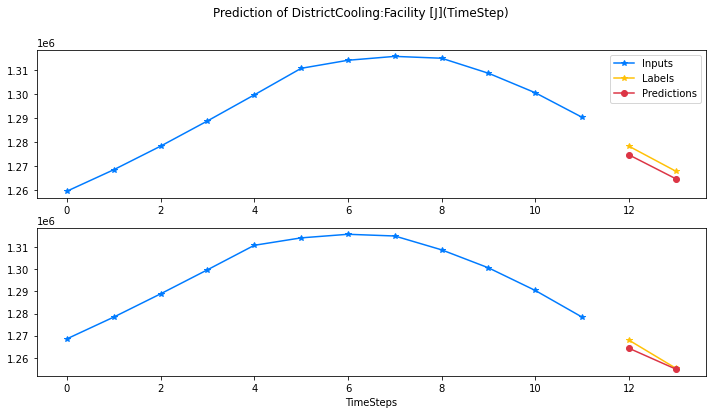

In [41]:
w_cooling.plot2(model=multi_lstm_model, plot_col = column_to_predict_cooling, max_subplots=2)

w_indoor.plot(multi_lstm_model, plot_col = column_to_predict_indoor, max_subplots=3)


w_outdoor.plot(multi_lstm_model, plot_col = column_to_predict_outdoor,max_subplots=3)

w_outdoor_wide.plot(multi_lstm_model, plot_col = column_to_predict_outdoor_wide, max_subplots=3)

In [42]:
x_test_norm.head()

,Indoor_Mean,TimeStep,Electricity:Facility [J](TimeStep),DistrictCooling:Facility [J](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Wind Direction [deg](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)
65880,0.592477,2.881726,-0.647539,1.334480,1.086573,1.460580,1.120298,-1.886316,0.217654,1.458813
65881,0.592477,2.881763,-0.647539,1.353433,1.125126,1.459594,1.183411,-1.877255,0.199243,1.451375
65882,0.592477,2.881799,-0.647539,1.374261,1.163678,1.458607,1.246523,-1.868194,0.180832,1.443938
65883,0.592477,2.881836,-0.647539,1.396515,1.202231,1.413222,1.309636,-1.859133,0.162422,1.499718
65884,0.592477,2.881872,-0.647539,1.419530,1.240784,1.367837,1.372748,-1.850072,0.144011,1.555499


In [43]:
gigi = multi_lstm_model.predict(w_cooling.test)

In [44]:
gigi.shape

(13163, 2, 1)

In [45]:
test=gigi[:,:,0]
print(test)

[[ 1.3665657  1.3454523]
 [ 1.3443879  1.3244507]
 [ 1.3222284  1.3036022]
 ...
 [-1.0325166 -1.0783379]
 [-1.0633558 -1.1059781]
 [-1.0544838 -1.0944045]]


In [46]:
test_denorm = [[t[0]*std+mean,t[1]*std+mean ]for t in test]

In [47]:
print(type(test_denorm[0][0][0]))

<class 'numpy.float64'>


In [48]:
len(test_denorm)

13163

In [49]:
print((test_denorm[0][0]))

Indoor_Mean                                                                2.639971e+01
TimeStep                                                                   1.537190e+09
Electricity:Facility [J](TimeStep)                                         3.483028e+05
DistrictCooling:Facility [J](TimeStep)                                     1.274783e+06
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)             3.145252e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)     7.469039e+02
Environment:Site Wind Speed [m/s](TimeStep)                                7.517006e+00
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)            1.015030e+05
Environment:Site Wind Direction [deg](TimeStep)                            3.323409e+02
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)    2.020646e+02
dtype: float64


In [50]:
lista = []
for i in range(len(test_denorm)):
    lista.append(test_denorm[i][1][3])

lista_df = pd.DataFrame(lista)

In [51]:
lista_df

,0
0,1.264850e+06
1,1.254969e+06
2,1.245160e+06
3,1.234920e+06
4,1.225829e+06
...,...
13158,2.762515e+05
13159,1.401654e+05
13160,1.245074e+05
13161,1.115033e+05


Text(0.5, 1.0, 'DistrictCooling Facility Prediction')

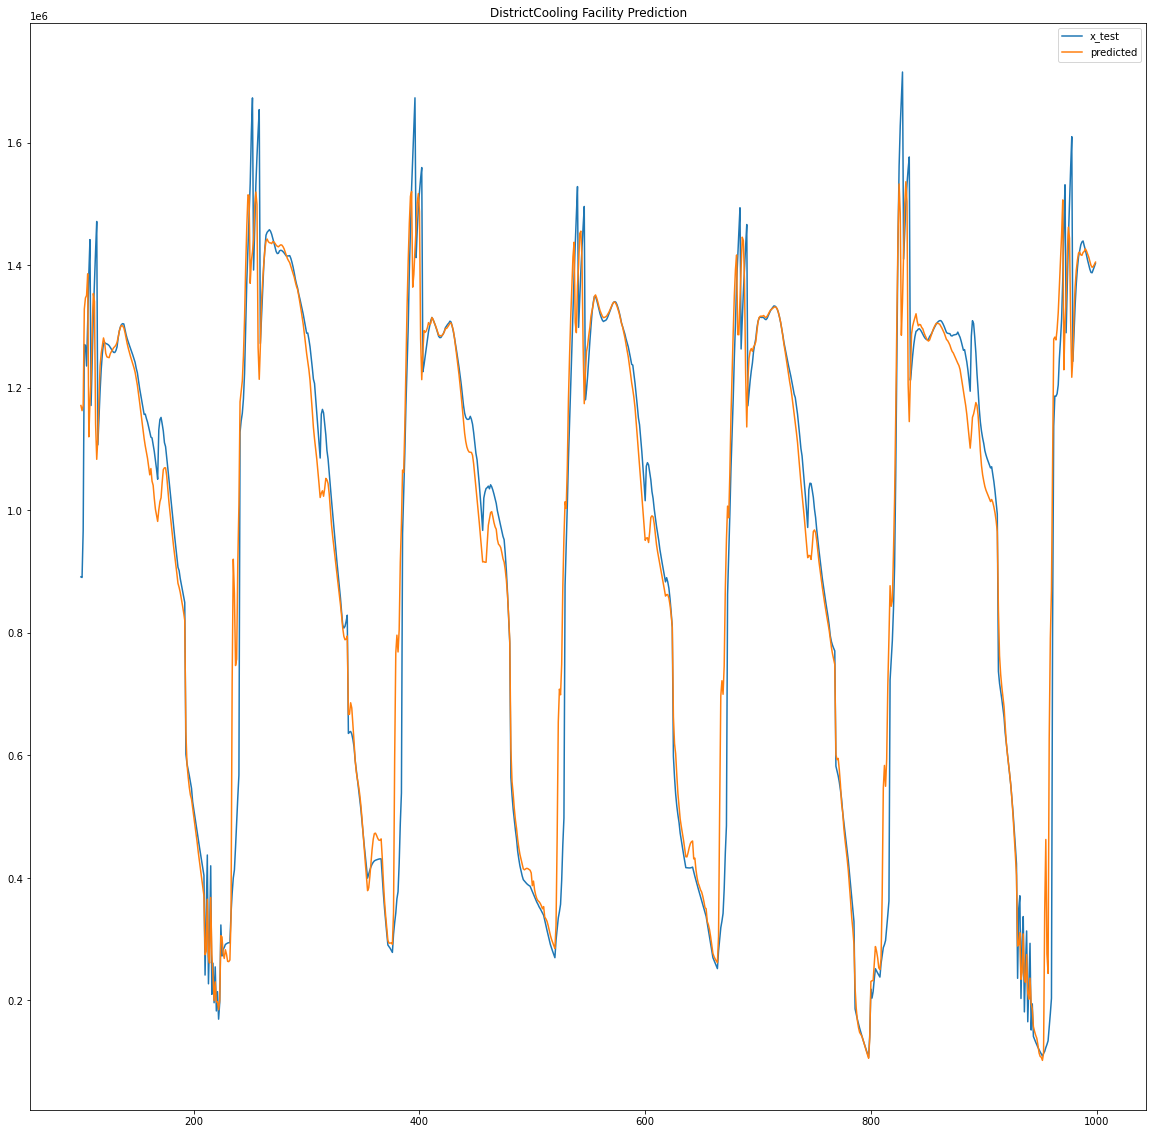

In [52]:
plt.figure(figsize=(20,20))
plot_test = x_test['DistrictCooling:Facility [J](TimeStep)'][11:].copy()
plot_test.reset_index(inplace=True,drop=True)
plt.plot(plot_test[100:1000])
plt.plot(lista_df[100:1000])
plt.legend(['x_test','predicted'])
plt.title("DistrictCooling Facility Prediction")

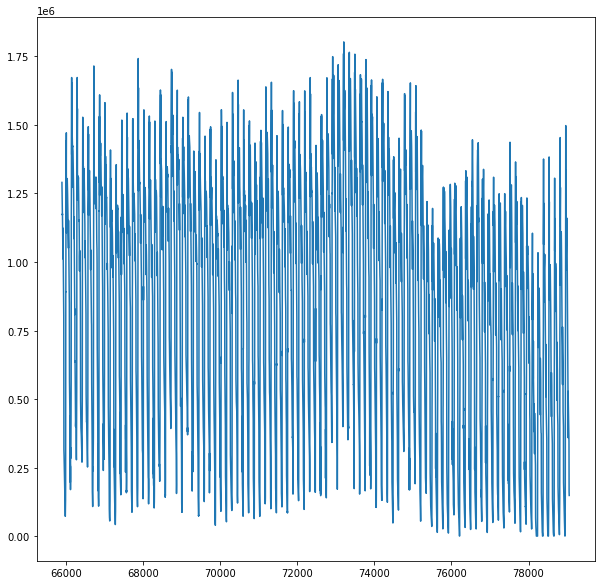

In [53]:
plt.figure(figsize=(10,10))

plt.plot(x_test['DistrictCooling:Facility [J](TimeStep)'][11:])

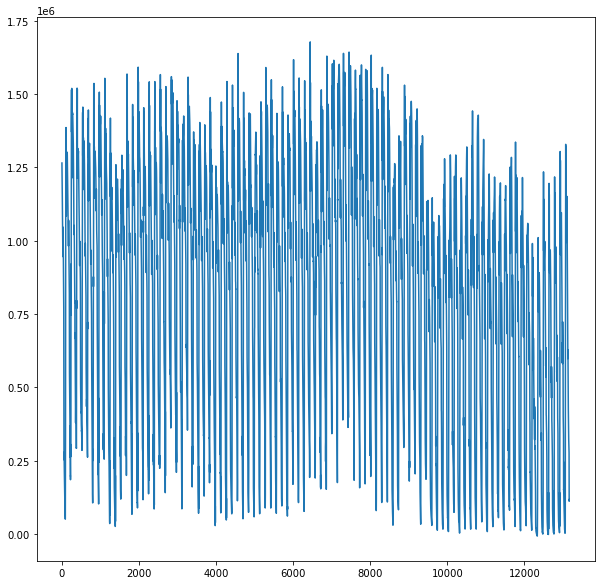

In [54]:
plt.figure(figsize=(10,10))

plt.plot(lista)